# ANÁLISIS DE CLUSTERING - ÍNDICE SINTÉTICO DE DIGITALIZACIÓN EDUCATIVA (ISDE)
## TFM: Máster en Análisis y Visualización de Datos Masivos - UNIR

---

**Autores:** José Miguel Martínez Martín & Rocío Noriega Bustelo  
**Fecha:** Enero 2026

---

### Objetivo
Aplicar técnicas de **Aprendizaje No Supervisado** para identificar **tipologías de países europeos** según su perfil de digitalización educativa, utilizando los datos armonizados de TALIS, UNESCO, Eurydice y Eurostat.

### Contenido
| Sección | Técnica | Objetivo |
|---------|---------|----------|
| 1 | Preparación de datos | Normalización y tratamiento de missings |
| 2 | K-Means | Clustering y determinación de k óptimo |
| 3 | Análisis de clusters | Perfiles e interpretación |
| 4 | Validación | Clustering jerárquico |
| 5 | Visualización | Mapas |

In [1]:
# ==============================================================================
# 1.1 IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
import warnings
warnings.filterwarnings('ignore')

# Sklearn - Clustering y métricas
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer

# Scipy - Clustering jerárquico
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Geopandas para mapas
try:
    import geopandas as gpd
    GEOPANDAS_OK = True
except:
    GEOPANDAS_OK = False
    print("geopandas no disponible - mapas desactivados")

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titleweight'] = 'bold'

# Paleta de colores para clusters
COLORES_CLUSTERS = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']

print("Librerías cargadas correctamente")

Librerías cargadas correctamente


In [2]:
# ==============================================================================
# 1.2 CARGA DE DATOS (DESDE EDA v8)
# ==============================================================================

# Datos de ejemplo basados en el EDA
paises = [
    'Albania','Austria','Bulgaria','Chequia','Chipre','Croacia','Dinamarca',
    'Eslovaquia','Eslovenia','España','Estonia','Finlandia','Francia','Hungría',
    'Italia','Letonia','Lituania','Macedonia del Norte','Malta','Montenegro',
    'Noruega','Países Bajos','Polonia','Portugal','Rumanía','Serbia','Suecia','Turquía'
]

data = {
    'D1': [55.00,66.20,61.60,65.80,42.80,64.60,70.20,64.60,65.60,68.80,66.10,68.90,60.50,64.70,57.80,63.90,65.20,60.60,63.20,62.60,70.20,71.00,63.40,65.80,58.10,60.50,68.30,63.20],
    'D2': [20.50,21.70,17.60,21.30,20.70,20.60,22.10,19.80,19.50,21.00,20.90,21.70,18.70,20.00,17.60,20.60,22.30,17.00,21.30,17.00,23.50,22.90,22.70,21.20,20.30,17.90,20.80,20.30],
    'D3': [43.60,35.60,32.30,39.20,37.60,41.30,41.20,34.40,41.20,41.30,37.40,38.70,40.80,39.50,35.20,38.10,41.30,32.20,43.20,40.80,33.30,29.50,34.90,33.10,27.70,39.50,38.10,34.30],
    'D4': [ 8.60,32.10,19.70,28.10,26.20,17.40,21.50,19.60,20.60,46.50,30.30,23.00,33.10,22.20,35.50,21.40,23.80,21.00,38.50,15.50,28.50,30.80,14.10,28.50,18.90,16.40,27.70,15.60],
    'D5': [24.40,36.80,23.40,31.90,33.60,33.90,46.90,36.00,30.90,34.60,27.90,33.30,37.40,30.40,29.90,23.70,25.80,23.00,35.30,21.10,40.50,46.50,32.60,33.10,22.90,27.70,38.90,27.60]
}

df_isde = pd.DataFrame(data, index=paises)

print(f"\nDataset ISDE cargado: {df_isde.shape[0]} países x {df_isde.shape[1]} dimensiones")
print(f"\nDimensiones: {df_isde.columns.tolist()}")
print(f"\nPaíses: {df_isde.index.tolist()}")
df_isde


Dataset ISDE cargado: 28 países x 5 dimensiones

Dimensiones: ['D1', 'D2', 'D3', 'D4', 'D5']

Países: ['Albania', 'Austria', 'Bulgaria', 'Chequia', 'Chipre', 'Croacia', 'Dinamarca', 'Eslovaquia', 'Eslovenia', 'España', 'Estonia', 'Finlandia', 'Francia', 'Hungría', 'Italia', 'Letonia', 'Lituania', 'Macedonia del Norte', 'Malta', 'Montenegro', 'Noruega', 'Países Bajos', 'Polonia', 'Portugal', 'Rumanía', 'Serbia', 'Suecia', 'Turquía']


,D1,D2,D3,D4,D5
Albania,55.0,20.5,43.6,8.6,24.4
Austria,66.2,21.7,35.6,32.1,36.8
Bulgaria,61.6,17.6,32.3,19.7,23.4
Chequia,65.8,21.3,39.2,28.1,31.9
Chipre,42.8,20.7,37.6,26.2,33.6
Croacia,64.6,20.6,41.3,17.4,33.9
Dinamarca,70.2,22.1,41.2,21.5,46.9
Eslovaquia,64.6,19.8,34.4,19.6,36.0
Eslovenia,65.6,19.5,41.2,20.6,30.9
España,68.8,21.0,41.3,46.5,34.6


ESTADÍSTICAS DESCRIPTIVAS POR DIMENSIÓN
          D1     D2     D3     D4     D5
count  28.00  28.00  28.00  28.00  28.00
mean   63.54  20.41  37.33  24.47  31.79
std     5.63   1.76   4.14   8.24   6.75
min    42.80  17.00  27.70   8.60  21.10
25%    61.35  19.73  34.38  19.42  27.15
50%    64.60  20.65  38.10  22.60  32.25
75%    66.12  21.40  40.90  28.95  35.47
max    71.00  23.50  43.60  46.50  46.90

VALORES FALTANTES
Sin valores faltantes


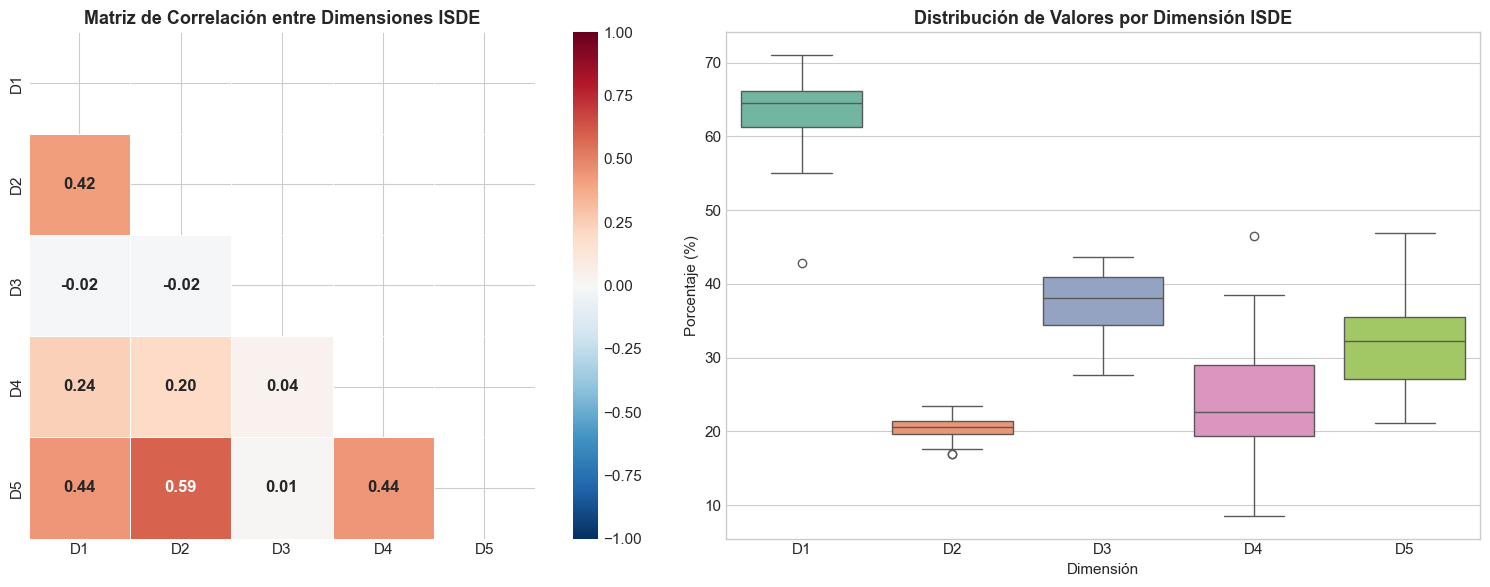


INSIGHTS PRELIMINARES
   - Dimensión con MAYOR varianza: D4 (67.9)
   - Dimensión con MENOR varianza: D2 (3.1)
   - D2 (Competencia Docente) es consistentemente BAJA en todos los países


In [3]:
# ==============================================================================
# 1.3 ANÁLISIS EXPLORATORIO PREVIO AL CLUSTERING
# ==============================================================================

print("="*70)
print("ESTADÍSTICAS DESCRIPTIVAS POR DIMENSIÓN")
print("="*70)
print(df_isde.describe().round(2))

# Valores faltantes
print("\n" + "="*70)
print("VALORES FALTANTES")
print("="*70)
missings = df_isde.isnull().sum()
print(missings[missings > 0] if missings.sum() > 0 else "Sin valores faltantes")

# Matriz de correlación
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap de correlación
ax1 = axes[0]
corr = df_isde.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, ax=ax1, vmin=-1, vmax=1,
            annot_kws={'size': 12, 'weight': 'bold'})
ax1.set_title('Matriz de Correlación entre Dimensiones ISDE', fontsize=13, fontweight='bold')

# Boxplot por dimensión
ax2 = axes[1]
df_melted = df_isde.melt(var_name='Dimensión', value_name='Valor')
sns.boxplot(data=df_melted, x='Dimensión', y='Valor', palette='Set2', ax=ax2)
ax2.set_title('Distribución de Valores por Dimensión ISDE', fontsize=13, fontweight='bold')
ax2.set_ylabel('Porcentaje (%)')

plt.tight_layout()
plt.show()

# Interpretación
print("\n" + "="*70)
print("INSIGHTS PRELIMINARES")
print("="*70)
print(f"   - Dimensión con MAYOR varianza: {df_isde.var().idxmax()} ({df_isde.var().max():.1f})")
print(f"   - Dimensión con MENOR varianza: {df_isde.var().idxmin()} ({df_isde.var().min():.1f})")
print(f"   - D2 (Competencia Docente) es consistentemente BAJA en todos los países")

In [4]:
# ==============================================================================
# 1.4 NORMALIZACIÓN DE DATOS
# ==============================================================================

# Imputar valores faltantes si los hay (KNN Imputer)
if df_isde.isnull().sum().sum() > 0:
    imputer = KNNImputer(n_neighbors=3)
    df_imputed = pd.DataFrame(imputer.fit_transform(df_isde), 
                               index=df_isde.index, columns=df_isde.columns)
    print("Valores faltantes imputados con KNN (k=3)")
else:
    df_imputed = df_isde.copy()
    print("Sin valores faltantes - datos listos")

# Normalización Z-score (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)
df_scaled = pd.DataFrame(X_scaled, index=df_isde.index, columns=df_isde.columns)

print(f"\nDatos normalizados (Z-score):")
print(f"   Media por dimensión: ~0")
print(f"   Desv. estándar: ~1")
print(df_scaled.describe().round(2).loc[['mean', 'std']])

Sin valores faltantes - datos listos

Datos normalizados (Z-score):
   Media por dimensión: ~0
   Desv. estándar: ~1
        D1    D2    D3    D4    D5
mean  0.00  0.00 -0.00 -0.00  0.00
std   1.02  1.02  1.02  1.02  1.02


---
## 2. CLUSTERING K-MEANS

### 2.1 Determinación del número óptimo de clusters (k)
Utilizamos dos métodos complementarios:
1. **Método del codo (Elbow)**: Inercia vs k
2. **Silhouette Score**: Cohesión y separación

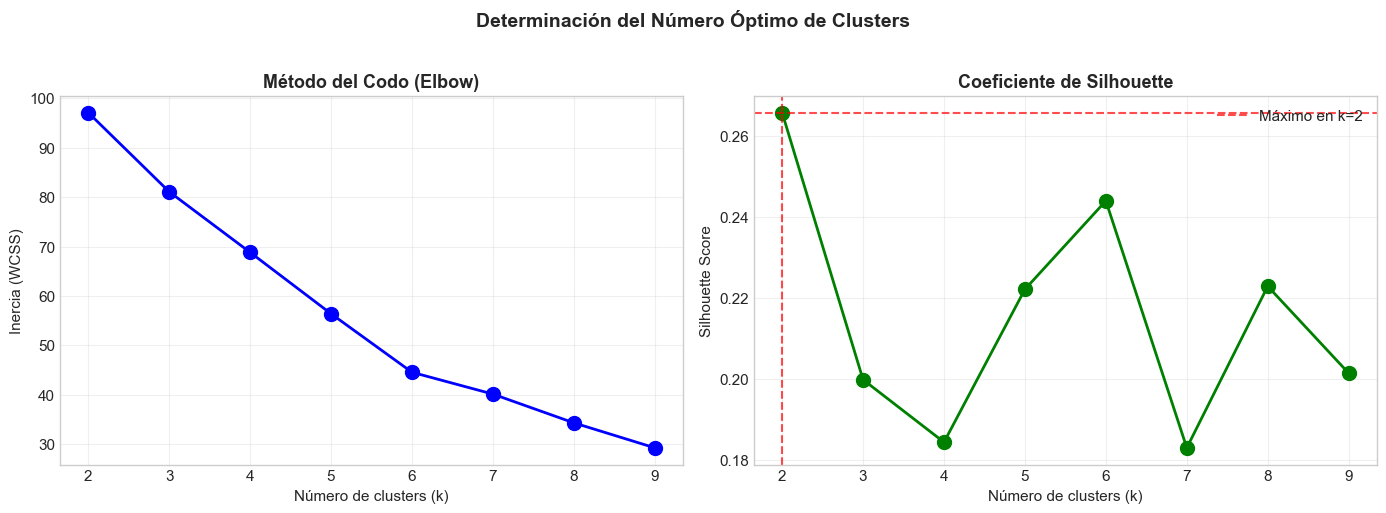


RESUMEN: k ÓPTIMO
   - Silhouette Score máximo en k = 2
   - Valor del Silhouette: 0.266

   Recomendación: Usar k = 2


In [5]:
# ==============================================================================
# 2.1 DETERMINACIÓN DEL k ÓPTIMO (ELBOW + SILHOUETTE)
# ==============================================================================

k_range = range(2, min(10, len(df_isde) - 1))

# Métricas para cada k
inertias = []
silhouettes = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Método del codo (Inercia)
ax1 = axes[0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=10)
ax1.set_xlabel('Número de clusters (k)', fontsize=11)
ax1.set_ylabel('Inercia (WCSS)', fontsize=11)
ax1.set_title('Método del Codo (Elbow)', fontweight='bold', fontsize=13)
ax1.set_xticks(list(k_range))
ax1.grid(True, alpha=0.3)

# 2. Silhouette
ax2 = axes[1]
ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=10)
k_optimo_sil = list(k_range)[silhouettes.index(max(silhouettes))]
ax2.axhline(y=max(silhouettes), color='r', linestyle='--', alpha=0.7, 
            label=f'Máximo en k={k_optimo_sil}')
ax2.axvline(x=k_optimo_sil, color='r', linestyle='--', alpha=0.7)
ax2.set_xlabel('Número de clusters (k)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Coeficiente de Silhouette', fontweight='bold', fontsize=13)
ax2.set_xticks(list(k_range))
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.suptitle('Determinación del Número Óptimo de Clusters', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Resumen
print("\n" + "="*70)
print("RESUMEN: k ÓPTIMO")
print("="*70)
print(f"   - Silhouette Score máximo en k = {k_optimo_sil}")
print(f"   - Valor del Silhouette: {max(silhouettes):.3f}")
print(f"\n   Recomendación: Usar k = {k_optimo_sil}")

In [6]:
# ==============================================================================
# 2.2 K-MEANS CON k ÓPTIMO
# ==============================================================================

# Seleccionar k (ajustar según resultados anteriores)
K_OPTIMO = 2  # Cambiar si las métricas sugieren otro valor

# Aplicar K-Means
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=20)
df_isde['Cluster'] = kmeans_final.fit_predict(X_scaled)

print(f"\nK-Means aplicado con k = {K_OPTIMO}")
print(f"\nDistribución de países por cluster:")
for c in range(K_OPTIMO):
    paises_c = df_isde[df_isde['Cluster'] == c].index.tolist()
    print(f"\n   Cluster {c+1} ({len(paises_c)} países): {', '.join(paises_c)}")

# Métricas del clustering final
sil = silhouette_score(X_scaled, df_isde['Cluster'])

print(f"\n" + "="*70)
print(f"MÉTRICAS DEL CLUSTERING FINAL (k={K_OPTIMO})")
print("="*70)
print(f"   - Silhouette Score: {sil:.3f}  (rango: -1 a 1, > 0.5 es bueno)")


K-Means aplicado con k = 2

Distribución de países por cluster:

   Cluster 1 (18 países): Austria, Chequia, Croacia, Dinamarca, Eslovaquia, Eslovenia, España, Estonia, Finlandia, Francia, Hungría, Lituania, Malta, Noruega, Países Bajos, Polonia, Portugal, Suecia

   Cluster 2 (10 países): Albania, Bulgaria, Chipre, Italia, Letonia, Macedonia del Norte, Montenegro, Rumanía, Serbia, Turquía

MÉTRICAS DEL CLUSTERING FINAL (k=2)
   - Silhouette Score: 0.266  (rango: -1 a 1, > 0.5 es bueno)


---
## 3. ANÁLISIS E INTERPRETACIÓN DE CLUSTERS

Caracterizamos cada cluster según sus valores medios en las 5 dimensiones ISDE.

PERFIL DE CADA CLUSTER: VALORES MEDIOS POR DIMENSIÓN
                D1    D2    D3    D4    D5  ISDE_promedio  n_paises
Cluster 1     66.3  21.2  38.0  27.0  35.2           37.5      18.0
Cluster 2     58.6  19.0  36.1  19.9  25.7           31.9      10.0
Media Global  63.5  20.4  37.3  24.5  31.8           35.5      28.0


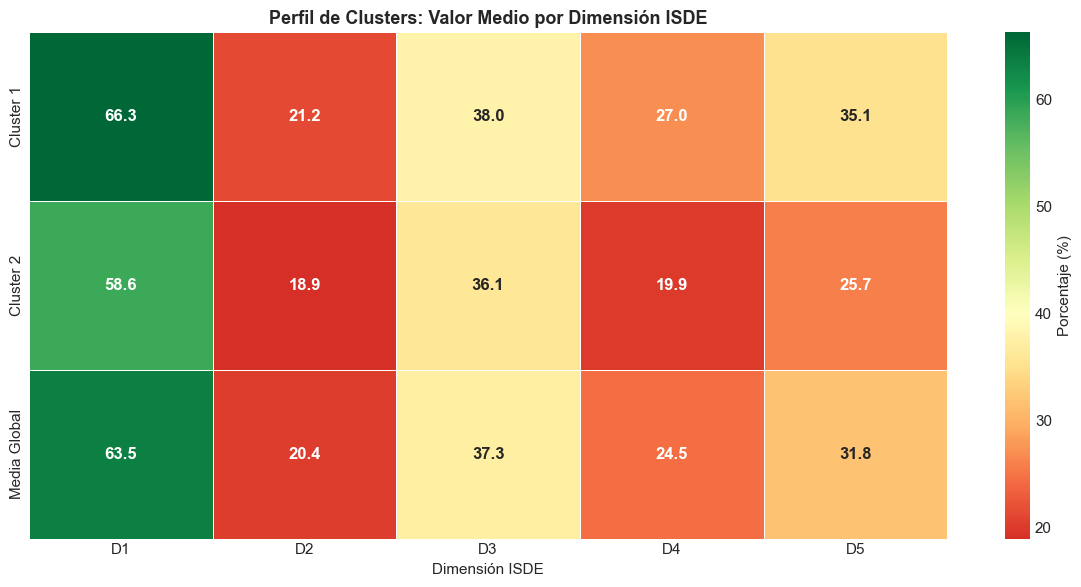

In [7]:
# ==============================================================================
# 3.1 PERFIL DE CADA CLUSTER (ESTADÍSTICOS)
# ==============================================================================

print("="*70)
print("PERFIL DE CADA CLUSTER: VALORES MEDIOS POR DIMENSIÓN")
print("="*70)

# Media global
dimensiones = ['D1', 'D2', 'D3', 'D4', 'D5']
media_global = df_isde[dimensiones].mean()

# Media por cluster
perfil_clusters = df_isde.groupby('Cluster')[dimensiones].mean()
perfil_clusters['ISDE_promedio'] = perfil_clusters.mean(axis=1)
perfil_clusters['n_paises'] = df_isde.groupby('Cluster').size()

# Renombrar índice
perfil_clusters.index = [f'Cluster {i+1}' for i in perfil_clusters.index]

# Añadir fila de media global
perfil_clusters.loc['Media Global'] = list(media_global) + [media_global.mean(), len(df_isde)]

print(perfil_clusters.round(1))

# Heatmap de perfiles
fig, ax = plt.subplots(figsize=(12, 6))

heatmap_data = perfil_clusters[dimensiones]
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=40,
            linewidths=0.5, annot_kws={'size': 12, 'weight': 'bold'},
            cbar_kws={'label': 'Porcentaje (%)'})

ax.set_title('Perfil de Clusters: Valor Medio por Dimensión ISDE', fontsize=13, fontweight='bold')
ax.set_xlabel('Dimensión ISDE')
ax.set_ylabel('')

plt.tight_layout()
plt.show()

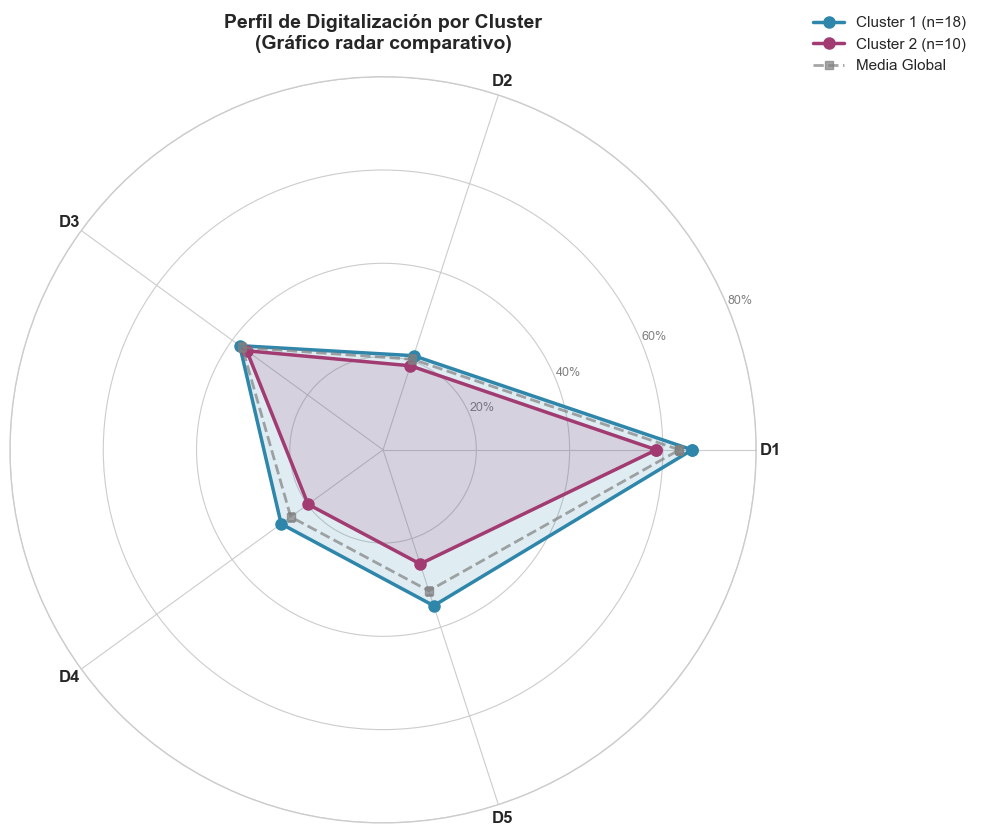

In [8]:
# ==============================================================================
# 3.2 RADAR COMPARATIVO DE CLUSTERS
# ==============================================================================

num_dims = len(dimensiones)

# Ángulos
angulos = [n / float(num_dims) * 2 * pi for n in range(num_dims)]
angulos += angulos[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Radar para cada cluster
for c in range(K_OPTIMO):
    valores = perfil_clusters.loc[f'Cluster {c+1}', dimensiones].values.tolist()
    valores += valores[:1]
    
    ax.plot(angulos, valores, 'o-', linewidth=2.5, color=COLORES_CLUSTERS[c],
            label=f'Cluster {c+1} (n={int(perfil_clusters.loc[f"Cluster {c+1}", "n_paises"])})',
            markersize=8)
    ax.fill(angulos, valores, alpha=0.15, color=COLORES_CLUSTERS[c])

# Media global (línea punteada)
valores_media = perfil_clusters.loc['Media Global', dimensiones].values.tolist()
valores_media += valores_media[:1]
ax.plot(angulos, valores_media, 's--', linewidth=2, color='gray',
        label='Media Global', markersize=6, alpha=0.7)

# Configuración
ax.set_xticks(angulos[:-1])
ax.set_xticklabels(dimensiones, fontsize=12, fontweight='bold')
ax.set_ylim(0, 80)
ax.set_yticks([20, 40, 60, 80])
ax.set_yticklabels(['20%', '40%', '60%', '80%'], fontsize=9, color='gray')

ax.set_title('Perfil de Digitalización por Cluster\n(Gráfico radar comparativo)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)

plt.tight_layout()
plt.show()

In [9]:
# ==============================================================================
# 3.3 INTERPRETACIÓN Y ETIQUETADO DE CLUSTERS
# ==============================================================================

print("="*70)
print("INTERPRETACIÓN DE CLUSTERS")
print("="*70)

# Analizar cada cluster
for c in range(K_OPTIMO):
    cluster_name = f'Cluster {c+1}'
    perfil = perfil_clusters.loc[cluster_name, dimensiones]
    media = perfil_clusters.loc['Media Global', dimensiones]
    
    # Calcular diferencias respecto a la media
    diff = perfil - media
    
    # Fortalezas y debilidades
    fortalezas = diff[diff > 3].index.tolist()  # >3 puntos sobre media
    debilidades = diff[diff < -3].index.tolist()  # <3 puntos bajo media
    
    paises = df_isde[df_isde['Cluster'] == c].index.tolist()
    isde = perfil_clusters.loc[cluster_name, 'ISDE_promedio']
    
    print(f"\n{'='*50}")
    print(f"{cluster_name.upper()} (ISDE: {isde:.1f}%)")
    print(f"{'='*50}")
    print(f"   Países ({len(paises)}): {', '.join(paises)}")
    print(f"   Fortalezas (>media): {', '.join(fortalezas) if fortalezas else 'Ninguna destacada'}")
    print(f"   Debilidades (<media): {', '.join(debilidades) if debilidades else 'Ninguna destacada'}")

# Propuesta de etiquetas
print("\n" + "="*70)
print("PROPUESTA DE ETIQUETAS PARA LOS CLUSTERS")
print("="*70)
print("""
   Basándose en el perfil de cada cluster, se sugieren las siguientes etiquetas:
   
   - Cluster con ISDE alto y D4 alto: "Líderes Digitales"
   - Cluster con ISDE medio y D1 alto: "Infraestructura sin Pedagogía"
   - Cluster con ISDE bajo y D4 bajo: "Rezagados en Liderazgo"
   
   (Ajustar según los resultados reales del clustering)
""")

INTERPRETACIÓN DE CLUSTERS

CLUSTER 1 (ISDE: 37.5%)
   Países (18): Austria, Chequia, Croacia, Dinamarca, Eslovaquia, Eslovenia, España, Estonia, Finlandia, Francia, Hungría, Lituania, Malta, Noruega, Países Bajos, Polonia, Portugal, Suecia
   Fortalezas (>media): D5
   Debilidades (<media): Ninguna destacada

CLUSTER 2 (ISDE: 31.9%)
   Países (10): Albania, Bulgaria, Chipre, Italia, Letonia, Macedonia del Norte, Montenegro, Rumanía, Serbia, Turquía
   Fortalezas (>media): Ninguna destacada
   Debilidades (<media): D1, D4, D5

PROPUESTA DE ETIQUETAS PARA LOS CLUSTERS

   Basándose en el perfil de cada cluster, se sugieren las siguientes etiquetas:

   - Cluster con ISDE alto y D4 alto: "Líderes Digitales"
   - Cluster con ISDE medio y D1 alto: "Infraestructura sin Pedagogía"
   - Cluster con ISDE bajo y D4 bajo: "Rezagados en Liderazgo"

   (Ajustar según los resultados reales del clustering)



---
## 4. VALIDACIÓN: CLUSTERING JERÁRQUICO

Para validar los resultados de K-Means, aplicamos también clustering jerárquico aglomerativo.

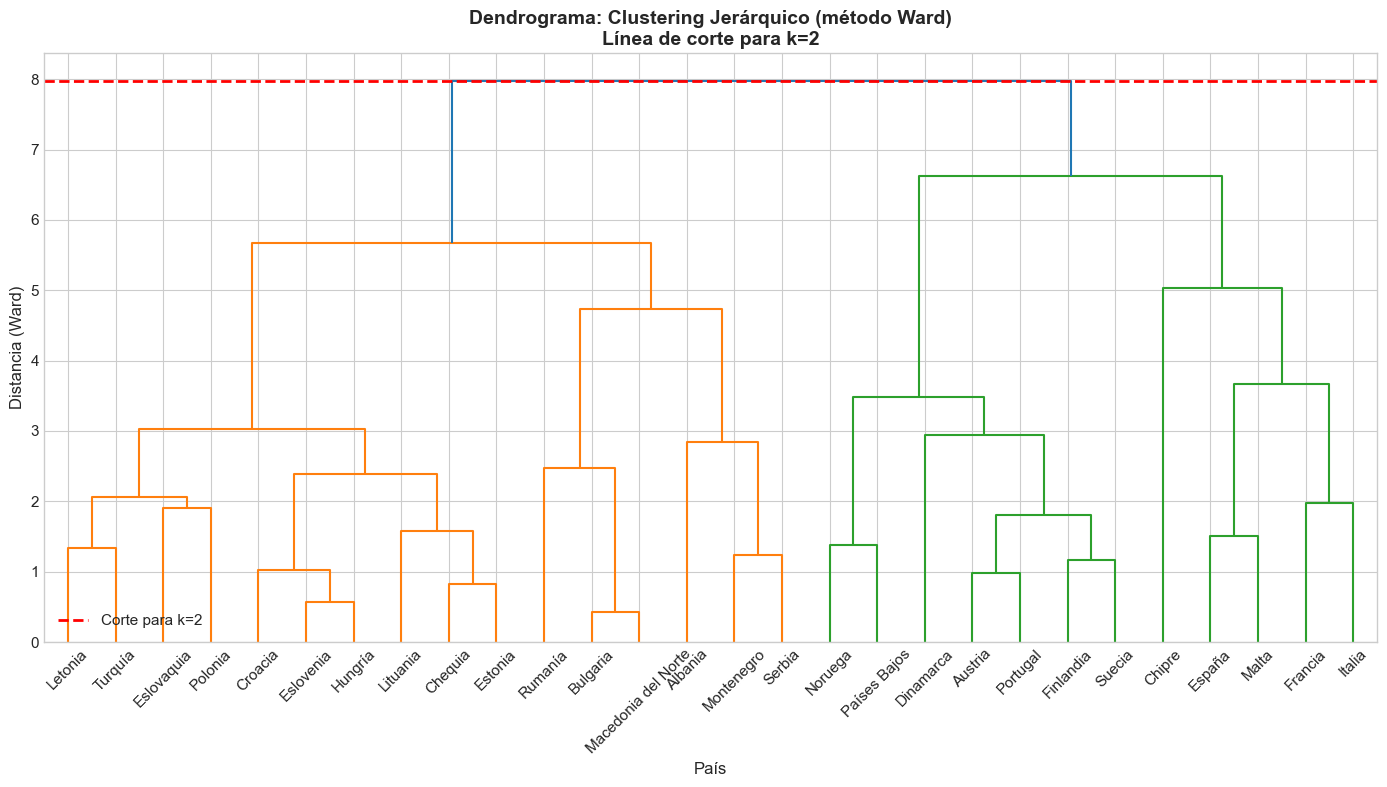


Comparación K-Means vs Jerárquico:
Jerárquico  0   1
K-Means          
0           8  10
1           8   2


In [10]:
# ==============================================================================
# 4.1 DENDROGRAMA (CLUSTERING JERÁRQUICO)
# ==============================================================================

fig, ax = plt.subplots(figsize=(14, 8))

# Linkage (método Ward = minimiza varianza intra-cluster)
linkage_matrix = linkage(X_scaled, method='ward')

# Dendrograma
dendrogram(linkage_matrix, labels=df_isde.index.tolist(), ax=ax,
           leaf_rotation=45, leaf_font_size=11,
           color_threshold=linkage_matrix[-K_OPTIMO+1, 2])

ax.set_title(f'Dendrograma: Clustering Jerárquico (método Ward)\nLínea de corte para k={K_OPTIMO}', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('País', fontsize=12)
ax.set_ylabel('Distancia (Ward)', fontsize=12)

# Línea de corte
ax.axhline(y=linkage_matrix[-K_OPTIMO+1, 2], color='r', linestyle='--', linewidth=2,
           label=f'Corte para k={K_OPTIMO}')
ax.legend()

plt.tight_layout()
plt.show()

# Comparar asignaciones
hierarchical_labels = fcluster(linkage_matrix, K_OPTIMO, criterion='maxclust') - 1
df_isde['Cluster_Jerarquico'] = hierarchical_labels

print("\nComparación K-Means vs Jerárquico:")
print(pd.crosstab(df_isde['Cluster'], df_isde['Cluster_Jerarquico'],
                  rownames=['K-Means'], colnames=['Jerárquico']))

---
## 5. VISUALIZACIÓN FINAL

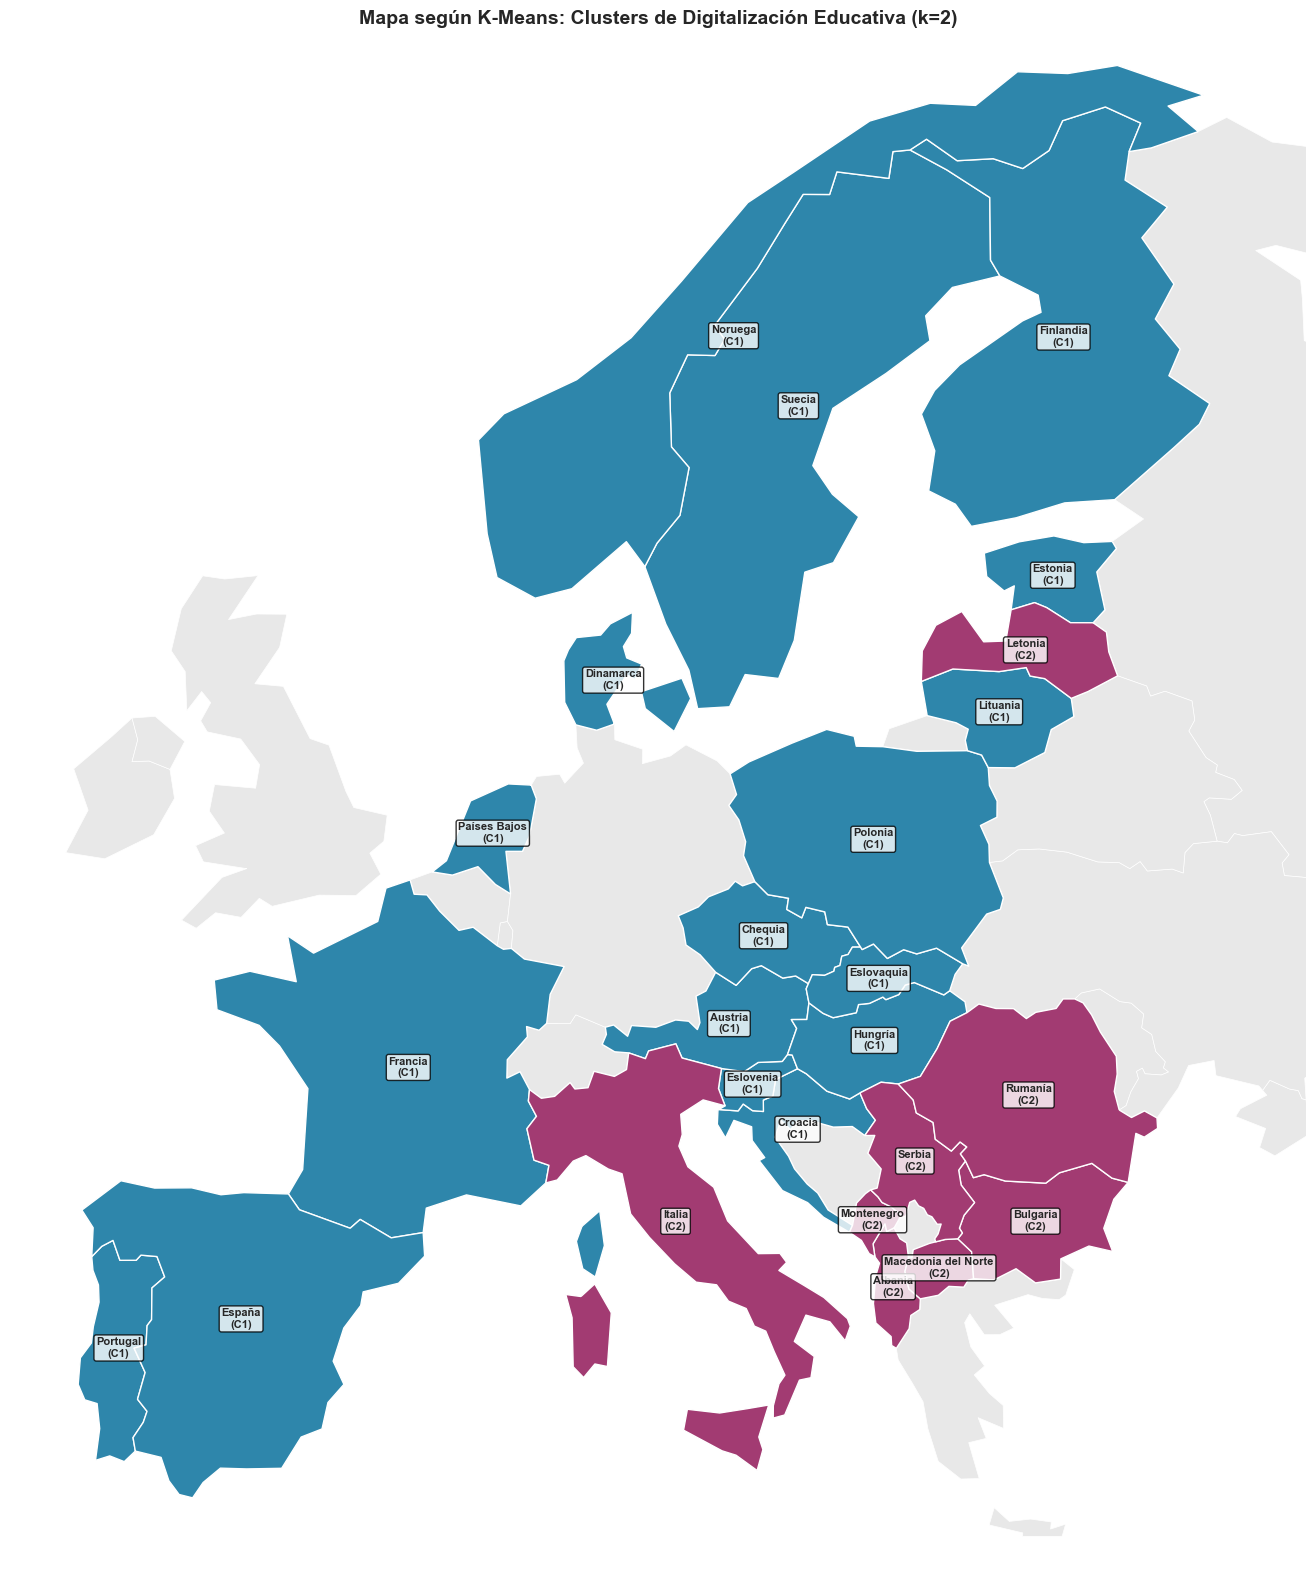

In [11]:
# ==============================================================================
# 5.1 MAPA DE EUROPA COLOREADO POR CLUSTER
# ==============================================================================

if GEOPANDAS_OK:
    # Diccionario de países a ISO3
    PAISES_A_ISO3 = {
    'España': 'ESP',
    'Dinamarca': 'DNK',
    'Austria': 'AUT',
    'Francia': 'FRA',
    'Chequia': 'CZE',
    'Finlandia': 'FIN',
    'Estonia': 'EST',
    'Croacia': 'HRV',
    'Hungría': 'HUN',
    'Italia': 'ITA',
    'Lituania': 'LTU',
    'Chipre': 'CYP',
    'Bulgaria': 'BGR',
    'Albania': 'ALB',
    'Eslovaquia': 'SVK',
    'Eslovenia': 'SVN',
    'Letonia': 'LVA',
    'Macedonia del Norte': 'MKD',
    'Malta': 'MLT',
    'Montenegro': 'MNE',
    'Noruega': 'NOR',
    'Países Bajos': 'NLD',
    'Polonia': 'POL',
    'Portugal': 'PRT',
    'Rumanía': 'ROU',
    'Serbia': 'SRB',
    'Suecia': 'SWE',
    'Turquía': 'TUR'
}

    
    # Cargar mapa
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    world.columns = world.columns.str.lower()
    
    # Correcciones ISO
    world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
    world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
    
    # Filtrar Europa y recortar
    europa = world[world['continent'] == 'Europe'].copy()
    bbox = [-20, 35, 45, 75]
    europa = europa.clip(bbox)
    
    # Preparar datos
    df_mapa = df_isde.reset_index()
    df_mapa.columns = ['Pais'] + list(df_mapa.columns[1:])
    df_mapa['ISO3'] = df_mapa['Pais'].map(PAISES_A_ISO3)
    
    # Merge
    europa_clusters = europa.merge(df_mapa[['ISO3', 'Cluster', 'Pais']], 
                                   left_on='iso_a3', right_on='ISO3', how='left')
    
    # Crear mapa
    fig, ax = plt.subplots(figsize=(14, 16))
    
    # Fondo
    europa.plot(ax=ax, color='#E8E8E8', edgecolor='white', linewidth=0.5)
    
    # Países con cluster
    for c in range(K_OPTIMO):
        subset = europa_clusters[europa_clusters['Cluster'] == c]
        if len(subset) > 0:
            subset.plot(ax=ax, color=COLORES_CLUSTERS[c], edgecolor='white', 
                       linewidth=1, label=f'Cluster {c+1}')
    
    # Etiquetas
    for idx, row in europa_clusters[europa_clusters['Cluster'].notna()].iterrows():
        centroid = row.geometry.centroid
        c = int(row['Cluster'])
        ax.annotate(f"{row['Pais']}\n(C{c+1})", xy=(centroid.x, centroid.y),
                   ha='center', va='center', fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    ax.set_xlim([-12, 35])
    ax.set_ylim([34, 72])
    ax.axis('off')
    ax.set_title(f'Mapa según K-Means: Clusters de Digitalización Educativa (k={K_OPTIMO})',
                fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
else:
    print("Mapa no disponible (instalar geopandas)")

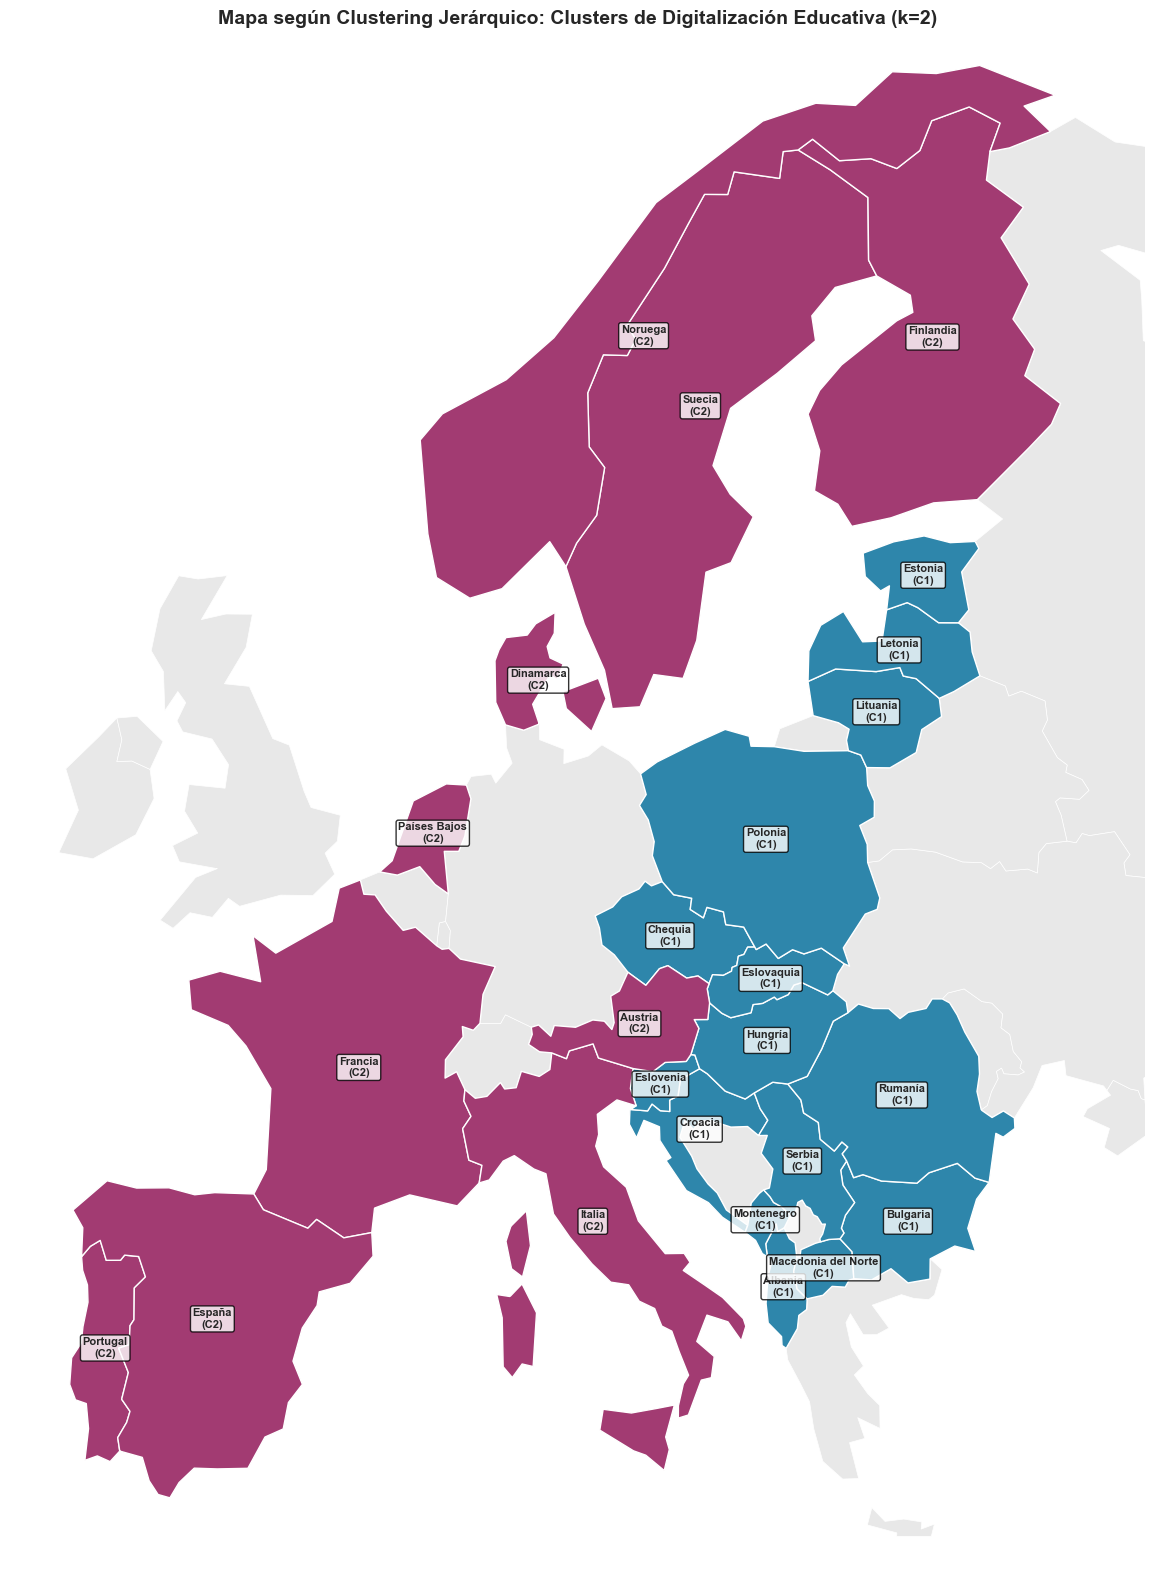

In [12]:
# ==============================================================================
# 5.1 MAPA DE EUROPA COLOREADO POR CLUSTER
# ==============================================================================

if GEOPANDAS_OK:
    # Diccionario de países a ISO3
    PAISES_A_ISO3 = {
    'España': 'ESP',
    'Dinamarca': 'DNK',
    'Austria': 'AUT',
    'Francia': 'FRA',
    'Chequia': 'CZE',
    'Finlandia': 'FIN',
    'Estonia': 'EST',
    'Croacia': 'HRV',
    'Hungría': 'HUN',
    'Italia': 'ITA',
    'Lituania': 'LTU',
    'Chipre': 'CYP',
    'Bulgaria': 'BGR',
    'Albania': 'ALB',
    'Eslovaquia': 'SVK',
    'Eslovenia': 'SVN',
    'Letonia': 'LVA',
    'Macedonia del Norte': 'MKD',
    'Malta': 'MLT',
    'Montenegro': 'MNE',
    'Noruega': 'NOR',
    'Países Bajos': 'NLD',
    'Polonia': 'POL',
    'Portugal': 'PRT',
    'Rumanía': 'ROU',
    'Serbia': 'SRB',
    'Suecia': 'SWE',
    'Turquía': 'TUR'
}

    
    # Cargar mapa
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    world.columns = world.columns.str.lower()
    
    # Correcciones ISO
    world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
    world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
    
    # Filtrar Europa y recortar
    europa = world[world['continent'] == 'Europe'].copy()
    bbox = [-20, 35, 45, 75]
    europa = europa.clip(bbox)
    
    # Preparar datos
    df_mapa = df_isde.reset_index()
    df_mapa.columns = ['Pais'] + list(df_mapa.columns[1:])
    df_mapa['ISO3'] = df_mapa['Pais'].map(PAISES_A_ISO3)
    
    # Merge
    europa_clusters = europa.merge(df_mapa[['ISO3', 'Cluster_Jerarquico', 'Pais']], 
                                   left_on='iso_a3', right_on='ISO3', how='left')
    
    # Crear mapa
    fig, ax = plt.subplots(figsize=(14, 16))
    
    # Fondo
    europa.plot(ax=ax, color='#E8E8E8', edgecolor='white', linewidth=0.5)
    
    # Países con cluster
    for c in range(K_OPTIMO):
        subset = europa_clusters[europa_clusters['Cluster_Jerarquico'] == c]
        if len(subset) > 0:
            subset.plot(ax=ax, color=COLORES_CLUSTERS[c], edgecolor='white', 
                       linewidth=1, label=f'Cluster_Jerarquico {c+1}')
    
    # Etiquetas
    for idx, row in europa_clusters[europa_clusters['Cluster_Jerarquico'].notna()].iterrows():
        centroid = row.geometry.centroid
        c = int(row['Cluster_Jerarquico'])
        ax.annotate(f"{row['Pais']}\n(C{c+1})", xy=(centroid.x, centroid.y),
                   ha='center', va='center', fontsize=8, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    ax.set_xlim([-12, 35])
    ax.set_ylim([34, 72])
    ax.axis('off')
    ax.set_title(f'Mapa según Clustering Jerárquico: Clusters de Digitalización Educativa (k={K_OPTIMO})',
                fontsize=14, fontweight='bold')
    ax.legend(loc='lower left', fontsize=11)
    
    plt.tight_layout()
    plt.show()
else:
    print("Mapa no disponible (instalar geopandas)")

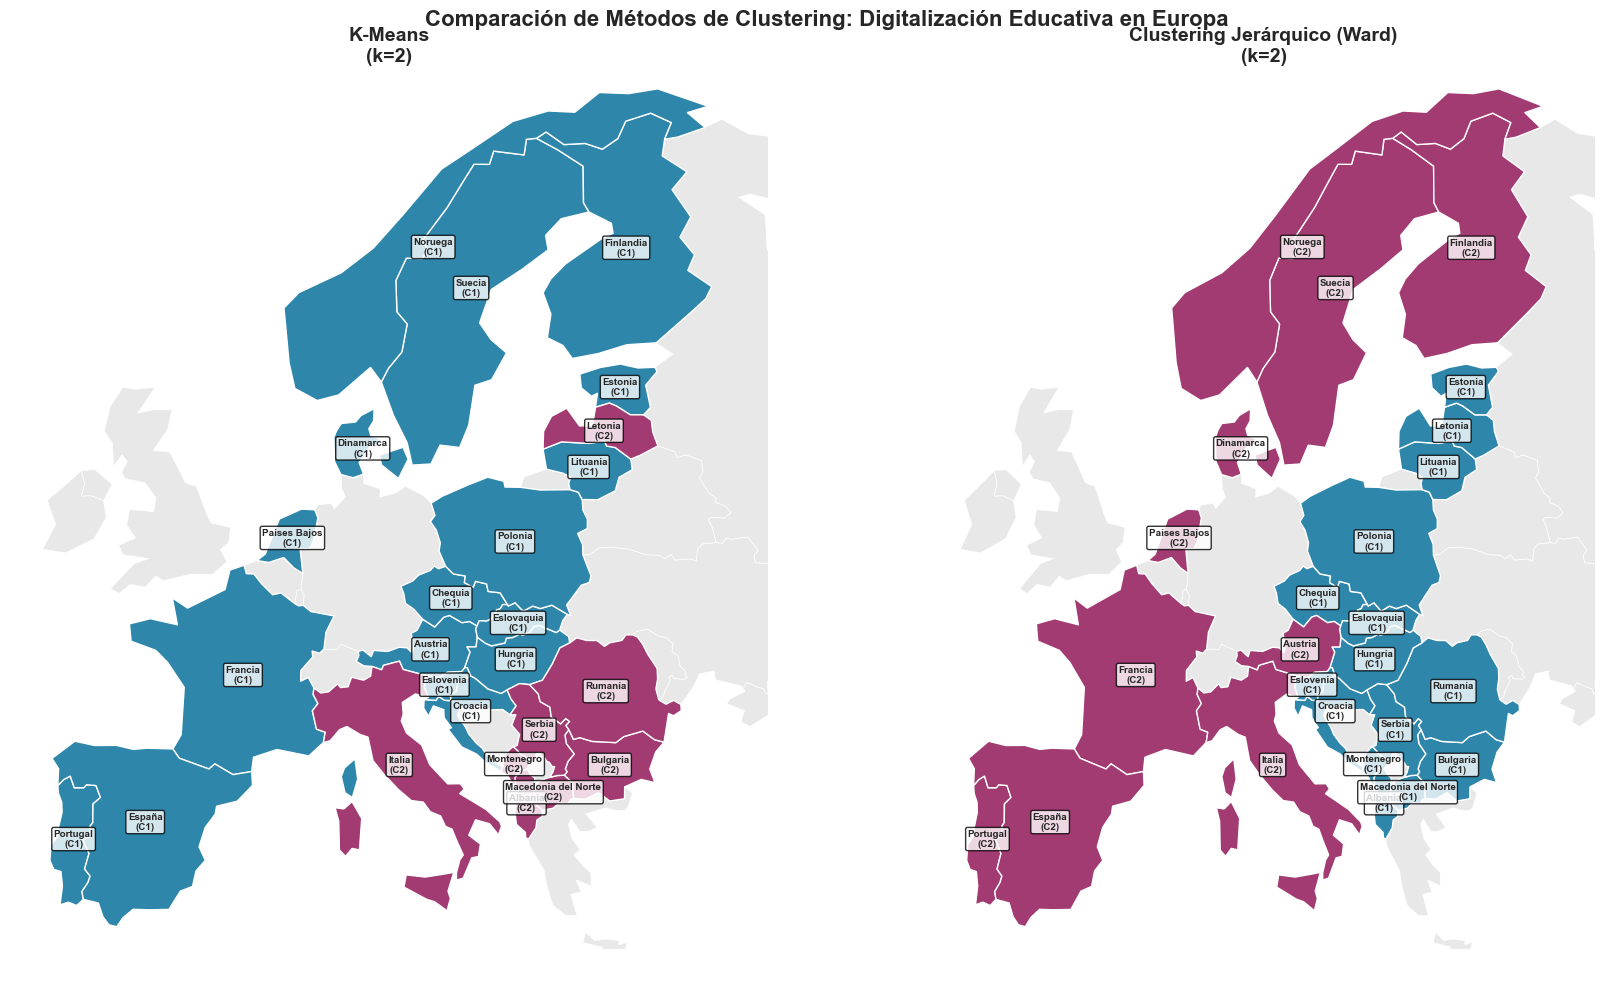


COMPARACIÓN DE ASIGNACIONES: K-MEANS vs JERÁRQUICO

Tabla de contingencia:
Jerárquico  0   1
K-Means          
0           8  10
1           8   2

→ Países con MISMA asignación: 10 (35.7%)
→ Países con DIFERENTE asignación: 18 (64.3%)

Países que cambian de cluster:
                     K-Means  Jerárquico
Albania                    2           1
Austria                    1           2
Bulgaria                   2           1
Dinamarca                  1           2
España                     1           2
Finlandia                  1           2
Francia                    1           2
Letonia                    2           1
Macedonia del Norte        2           1
Malta                      1           2
Montenegro                 2           1
Noruega                    1           2
Países Bajos               1           2
Portugal                   1           2
Rumanía                    2           1
Serbia                     2           1
Suecia                     1      

In [13]:
##COMPARATIVA AMBOS
# ==============================================================================
# MAPA COMPARATIVO: K-MEANS vs CLUSTERING JERÁRQUICO
# ==============================================================================

if GEOPANDAS_OK:
    # Diccionario de países a ISO3
    PAISES_A_ISO3 = {
        'España': 'ESP', 'Dinamarca': 'DNK', 'Austria': 'AUT', 'Francia': 'FRA',
        'Chequia': 'CZE', 'Finlandia': 'FIN', 'Estonia': 'EST', 'Croacia': 'HRV',
        'Hungría': 'HUN', 'Italia': 'ITA', 'Lituania': 'LTU', 'Chipre': 'CYP',
        'Bulgaria': 'BGR', 'Albania': 'ALB', 'Eslovaquia': 'SVK', 'Eslovenia': 'SVN',
        'Letonia': 'LVA', 'Macedonia del Norte': 'MKD', 'Malta': 'MLT',
        'Montenegro': 'MNE', 'Noruega': 'NOR', 'Países Bajos': 'NLD',
        'Polonia': 'POL', 'Portugal': 'PRT', 'Rumanía': 'ROU', 'Serbia': 'SRB',
        'Suecia': 'SWE', 'Turquía': 'TUR'
    }
    
    # Cargar mapa
    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    world.columns = world.columns.str.lower()
    
    # Correcciones ISO
    world.loc[world['name'] == 'France', 'iso_a3'] = 'FRA'
    world.loc[world['name'] == 'Norway', 'iso_a3'] = 'NOR'
    
    # Filtrar Europa y recortar
    europa = world[world['continent'] == 'Europe'].copy()
    bbox = [-20, 35, 45, 75]
    europa = europa.clip(bbox)
    
    # Preparar datos
    df_mapa = df_isde.reset_index()
    df_mapa.columns = ['Pais'] + list(df_mapa.columns[1:])
    df_mapa['ISO3'] = df_mapa['Pais'].map(PAISES_A_ISO3)
    
    # Merge con ambos clusters
    europa_clusters = europa.merge(
        df_mapa[['ISO3', 'Cluster', 'Cluster_Jerarquico', 'Pais']], 
        left_on='iso_a3', right_on='ISO3', how='left'
    )
    
    # =========================================================================
    # CREAR FIGURA COMPARATIVA
    # =========================================================================
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # Configuración común
    metodos = [
        ('Cluster', 'K-Means', axes[0]),
        ('Cluster_Jerarquico', 'Clustering Jerárquico (Ward)', axes[1])
    ]
    
    for col_cluster, titulo, ax in metodos:
        # Fondo gris para países sin datos
        europa.plot(ax=ax, color='#E8E8E8', edgecolor='white', linewidth=0.5)
        
        # Colorear por cluster
        for c in range(K_OPTIMO):
            subset = europa_clusters[europa_clusters[col_cluster] == c]
            if len(subset) > 0:
                subset.plot(ax=ax, color=COLORES_CLUSTERS[c], edgecolor='white', 
                           linewidth=1, label=f'Cluster {c+1}')
        
        # Etiquetas de países
        for idx, row in europa_clusters[europa_clusters[col_cluster].notna()].iterrows():
            centroid = row.geometry.centroid
            c = int(row[col_cluster])
            ax.annotate(f"{row['Pais']}\n(C{c+1})", xy=(centroid.x, centroid.y),
                       ha='center', va='center', fontsize=7, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
        
        # Configuración del subplot
        ax.set_xlim([-12, 35])
        ax.set_ylim([34, 72])
        ax.axis('off')
        ax.set_title(f'{titulo}\n(k={K_OPTIMO})', fontsize=14, fontweight='bold')
        ax.legend(loc='lower left', fontsize=10)
    
    # Título general
    fig.suptitle('Comparación de Métodos de Clustering: Digitalización Educativa en Europa', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # =========================================================================
    # TABLA RESUMEN DE DIFERENCIAS
    # =========================================================================
    print("\n" + "="*70)
    print("COMPARACIÓN DE ASIGNACIONES: K-MEANS vs JERÁRQUICO")
    print("="*70)
    
    # Crosstab
    print("\nTabla de contingencia:")
    print(pd.crosstab(df_isde['Cluster'], df_isde['Cluster_Jerarquico'],
                      rownames=['K-Means'], colnames=['Jerárquico']))
    
    # Países con asignación diferente
    df_isde['Coincide'] = df_isde['Cluster'] == df_isde['Cluster_Jerarquico']
    n_coinciden = df_isde['Coincide'].sum()
    n_difieren = len(df_isde) - n_coinciden
    
    print(f"\n→ Países con MISMA asignación: {n_coinciden} ({100*n_coinciden/len(df_isde):.1f}%)")
    print(f"→ Países con DIFERENTE asignación: {n_difieren} ({100*n_difieren/len(df_isde):.1f}%)")
    
    if n_difieren > 0:
        print("\nPaíses que cambian de cluster:")
        diferentes = df_isde[~df_isde['Coincide']][['Cluster', 'Cluster_Jerarquico']].copy()
        diferentes.columns = ['K-Means', 'Jerárquico']
        diferentes['K-Means'] = diferentes['K-Means'] + 1  # Para mostrar C1, C2, C3
        diferentes['Jerárquico'] = diferentes['Jerárquico'] + 1
        print(diferentes.to_string())

else:
    print("Mapa no disponible (instalar geopandas)")

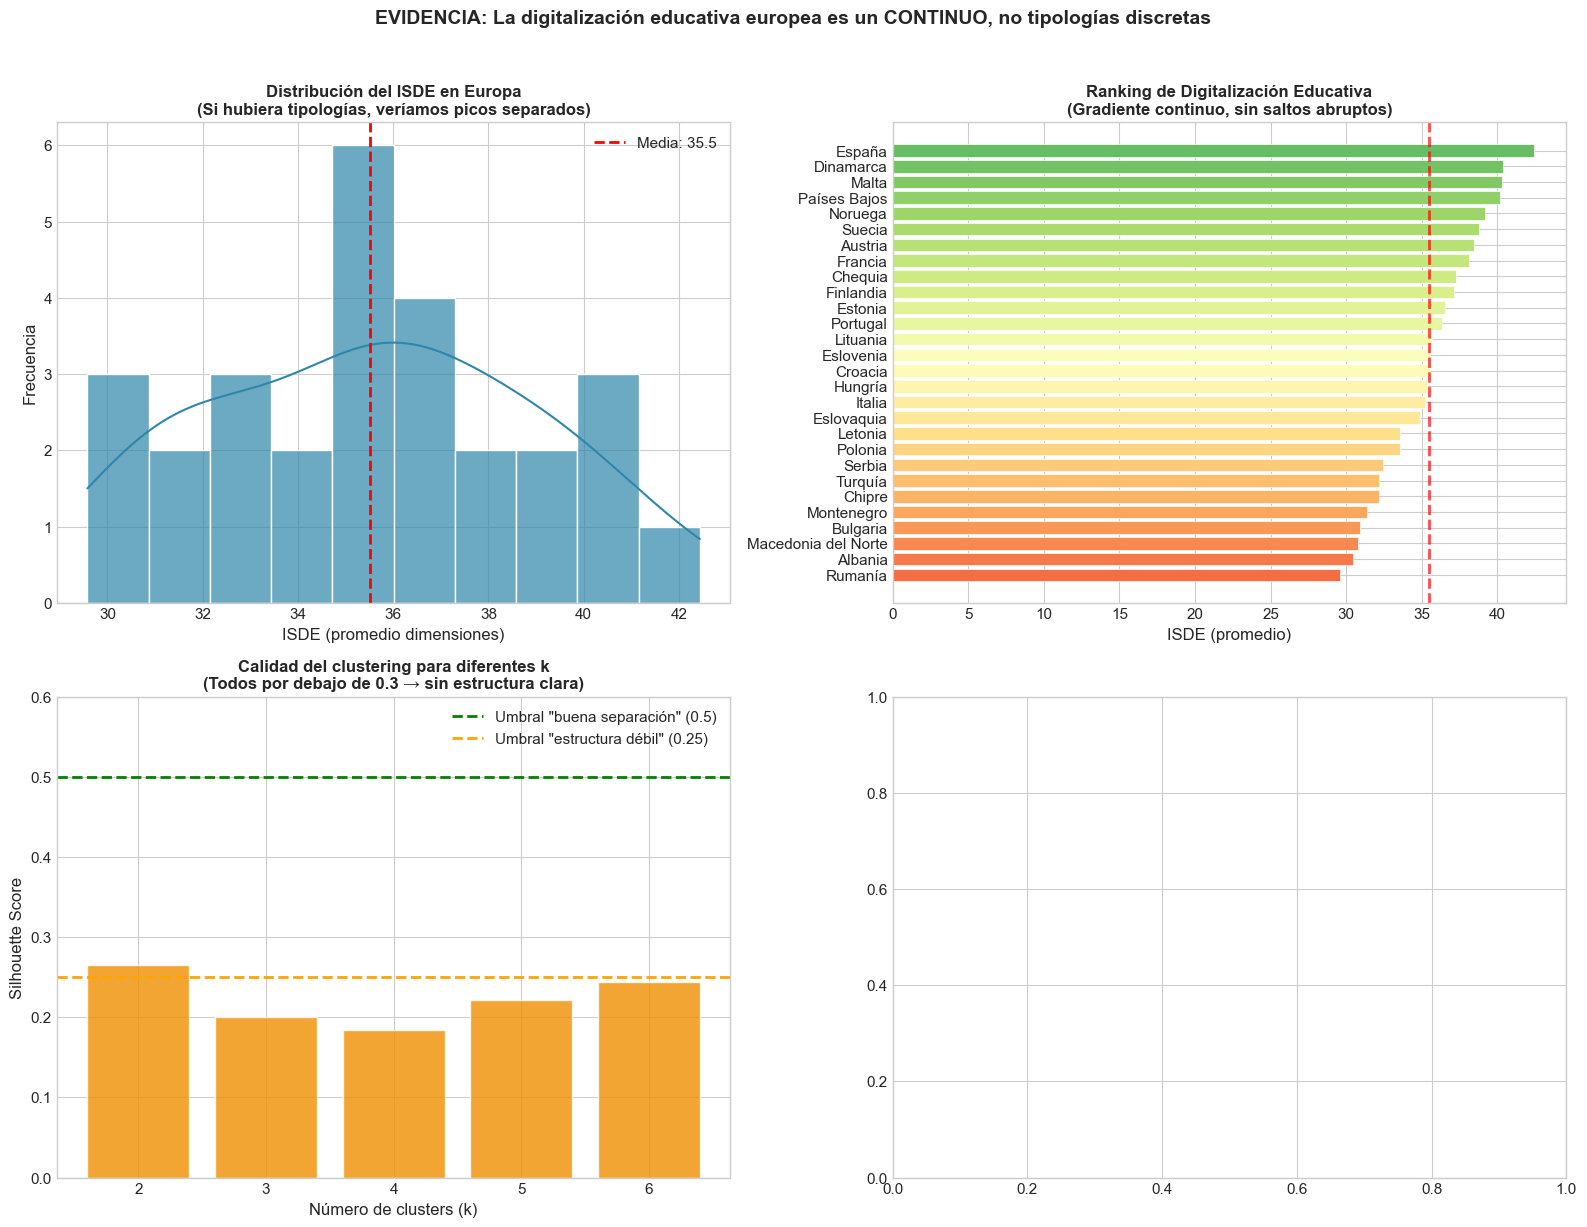

In [15]:
# ==============================================================================
# EVIDENCIA VISUAL: ¿CONTINUO O TIPOLOGÍAS DISCRETAS?
# ==============================================================================

# Calcular ISDE promedio por país (media de las 5 dimensiones)
df_isde['ISDE_mean'] = df_isde[dimensiones].mean(axis=1)

# Ordenar para visualización
df_ordenado = df_isde.sort_values('ISDE_mean', ascending=True)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# =========================================================================
# 1. HISTOGRAMA + DENSIDAD DEL ISDE
# =========================================================================
ax1 = axes[0, 0]
sns.histplot(df_isde['ISDE_mean'], bins=10, kde=True, color='#2E86AB', 
             edgecolor='white', alpha=0.7, ax=ax1)
ax1.axvline(df_isde['ISDE_mean'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f'Media: {df_isde["ISDE_mean"].mean():.1f}')
ax1.set_xlabel('ISDE (promedio dimensiones)', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)
ax1.set_title('Distribución del ISDE en Europa\n(Si hubiera tipologías, veríamos picos separados)', 
              fontsize=12, fontweight='bold')
ax1.legend()

# =========================================================================
# 2. GRÁFICO DE BARRAS ORDENADO (EL ESPECTRO)
# =========================================================================
ax2 = axes[0, 1]
colores = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(df_ordenado)))
bars = ax2.barh(df_ordenado.index, df_ordenado['ISDE_mean'], color=colores, 
                edgecolor='white', linewidth=0.5)
ax2.set_xlabel('ISDE (promedio)', fontsize=12)
ax2.set_title('Ranking de Digitalización Educativa\n(Gradiente continuo, sin saltos abruptos)', 
              fontsize=12, fontweight='bold')
ax2.axvline(df_isde['ISDE_mean'].mean(), color='red', linestyle='--', 
            linewidth=2, alpha=0.7)


# =========================================================================
# 3. COMPARACIÓN DE MÉTRICAS DE CLUSTERING
# =========================================================================
ax3 = axes[1, 0]

# Datos de métricas (del análisis previo)
k_values = [2, 3, 4, 5, 6]
silhouettes = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    silhouettes.append(silhouette_score(X_scaled, labels))

ax3.bar(k_values, silhouettes, color='#F18F01', edgecolor='white', alpha=0.8)
ax3.axhline(y=0.5, color='green', linestyle='--', linewidth=2, 
            label='Umbral "buena separación" (0.5)')
ax3.axhline(y=0.25, color='orange', linestyle='--', linewidth=2,
            label='Umbral "estructura débil" (0.25)')
ax3.set_xlabel('Número de clusters (k)', fontsize=12)
ax3.set_ylabel('Silhouette Score', fontsize=12)
ax3.set_title('Calidad del clustering para diferentes k\n(Todos por debajo de 0.3 → sin estructura clara)', 
              fontsize=12, fontweight='bold')
ax3.set_xticks(k_values)
ax3.legend(loc='upper right')
ax3.set_ylim(0, 0.6)

plt.suptitle('EVIDENCIA: La digitalización educativa europea es un CONTINUO, no tipologías discretas', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ==============================================================================
# 5.2 RESUMEN FINAL Y CONCLUSIONES
# ==============================================================================

print("""
======================================================================
                    RESUMEN DEL ANÁLISIS DE CLUSTERING                        
======================================================================
""")

print(f"CONFIGURACIÓN:")
print(f"   - Países analizados: {len(df_isde)}")
print(f"   - Dimensiones ISDE: {len(dimensiones)} (D1-D5)")
print(f"   - Número de clusters (k): {K_OPTIMO}")
print(f"   - Normalización: Z-score (StandardScaler)")

print(f"\nMÉTRICAS DE CALIDAD:")
print(f"   - Silhouette Score: {sil:.3f}")

print(f"\nCLUSTERS IDENTIFICADOS:")
for c in range(K_OPTIMO):
    paises = df_isde[df_isde['Cluster'] == c].index.tolist()
    isde = df_isde[df_isde['Cluster'] == c][dimensiones].mean().mean()
    print(f"   Cluster {c+1} (ISDE={isde:.1f}%): {', '.join(paises)}")

print("""
\nIMPLICACIONES PARA POLÍTICAS EDUCATIVAS:

   1. Los clusters revelan tipologías de países con perfiles de digitalización
      similares, lo que permite diseñar políticas adaptadas a cada grupo.
   
   2. D2 (Competencia Docente) es consistentemente baja en TODOS los clusters,
      lo que sugiere una prioridad común a nivel europeo.
   
   3. D4 (Liderazgo/Políticas) es la dimensión con mayor varianza entre clusters,
      indicando que el marco institucional marca la diferencia.
   
   4. Los países del cluster de menor ISDE podrían beneficiarse de programas
      de intercambio de buenas prácticas con los líderes digitales.
""")

# Guardar resultados
print("\n" + "="*70)
print("GUARDANDO RESULTADOS...")
print("="*70)

# Guardar dataset con clusters
df_isde.to_csv(r'C:\Users\Usuario\Desktop\UNIR\TFM\Tablas\isde_clusters.csv')
perfil_clusters.to_csv(r'C:\Users\Usuario\Desktop\UNIR\TFM\Tablas\perfil_clusters.csv')

print("   - isde_clusters.csv (países con asignación de cluster)")
print("   - perfil_clusters.csv (perfil medio por cluster)")


                    RESUMEN DEL ANÁLISIS DE CLUSTERING                        

CONFIGURACIÓN:
   - Países analizados: 28
   - Dimensiones ISDE: 5 (D1-D5)
   - Número de clusters (k): 2
   - Normalización: Z-score (StandardScaler)

MÉTRICAS DE CALIDAD:
   - Silhouette Score: 0.266

CLUSTERS IDENTIFICADOS:
   Cluster 1 (ISDE=37.5%): Austria, Chequia, Croacia, Dinamarca, Eslovaquia, Eslovenia, España, Estonia, Finlandia, Francia, Hungría, Lituania, Malta, Noruega, Países Bajos, Polonia, Portugal, Suecia
   Cluster 2 (ISDE=31.9%): Albania, Bulgaria, Chipre, Italia, Letonia, Macedonia del Norte, Montenegro, Rumanía, Serbia, Turquía


IMPLICACIONES PARA POLÍTICAS EDUCATIVAS:

   1. Los clusters revelan tipologías de países con perfiles de digitalización
      similares, lo que permite diseñar políticas adaptadas a cada grupo.

   2. D2 (Competencia Docente) es consistentemente baja en TODOS los clusters,
      lo que sugiere una prioridad común a nivel europeo.

   3. D4 (Liderazgo/Polític